In [1]:
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from botorch.models.transforms import Normalize

from xopt.vocs import VOCS
from lume_model.torch import LUMEModule

from utils import load_surrogate, create_vocs

In [2]:
# load surrogate model
surrogate = load_surrogate("configs/lcls_variables.yml", "configs/normalization.json", "torch_model.pt")
objective_name = "negative_sigma_xy"
vocs = create_vocs(surrogate, objective_name)
surrogate_module = LUMEModule(surrogate, surrogate.features, surrogate.outputs)

# Load/Generate Grid Data

In [3]:
path = "./corr_models/"
n_pts = 3  # points per grid dimension

# output directory
if not os.path.exists(path):
    os.makedirs(path)

In [4]:
x_dim = len(surrogate.features)
y_dim = len(surrogate.outputs)
raw_x_lim = torch.empty(x_dim, 2)
for i, name in enumerate(surrogate.features):
    if name in vocs.variable_names:
        raw_x_lim[i, :] = torch.tensor(vocs.variables[name])
    else:
        raw_x_lim[i, :] = torch.tensor([vocs.constants[name], vocs.constants[name]])
        
x_lim = raw_x_lim.clone()
for i in range(x_lim.shape[0]):
    if not x_lim[i, 0] < x_lim[i, 1]:
        old_value = x_lim[i, 0].clone()
        delta = 1e-2 * x_lim[i, 0]
        x_lim[i] = torch.tensor([old_value - delta, old_value + delta])

In [5]:
# load/generate grid data
def get_grid_data(save_data=True):
    file = path + "grid_data.pt"
    if os.path.isfile(file):
        grid_data = torch.load(file)
        x, y = grid_data["x"], grid_data["y"]
    else:
        x_i = [torch.linspace(*raw_x_lim[i], n_pts) for i in range(x_dim)]
        x = torch.cartesian_prod(*x_i)
        n_samples = x.shape[0]
        # calculate outputs in batches
        y = torch.empty((n_samples, y_dim))
        n_batch = 100
        batch_size = n_samples // n_batch
        for i in range(n_batch + 1):
            idx_start = i * batch_size
            idx_end = (i + 1) * batch_size
            if i == 100:
                idx_end = -1
            x_batch = x[idx_start:idx_end, :].double()
            with torch.no_grad():
                y[idx_start:idx_end] = surrogate_module(x_batch)
            frac = (n_batch + 1) // 10
            if i % frac == 0:
                print("Computing y-data, finished {:d}%".format(i * 10 // frac), end="\r")
        if save_data:
            if not os.path.exists(path):
                os.makedirs(path)
            torch.save({"x": x, "y": y}, file)
    return x, y

In [6]:
# load/generate in-/ouput transformers (normalization)
def get_transformers(save_data=True):
    file_x = path + "x_transformer.pt"
    file_y = path + "y_transformer.pt"
    if os.path.isfile(file_x) and os.path.isfile(file_y):
        x_transformer = Normalize(x_dim)
        x_transformer.eval()
        x_transformer.load_state_dict(torch.load(file_x))
        y_transformer = Normalize(y_dim)
        y_transformer.eval()
        y_transformer.load_state_dict(torch.load(file_y))
    else:
        # define in- and output transformers
        x_transformer = Normalize(x_dim, bounds=x_lim.T)
        y_lim = torch.stack((torch.min(y, dim=0)[0], torch.max(y, dim=0)[0])).T
        y_transformer = Normalize(y_dim, bounds=y_lim.T)
        if save_data:
            if not os.path.exists(path):
                os.makedirs(path)
            torch.save(x_transformer.state_dict(), file_x)
            torch.save(y_transformer.state_dict(), file_y)
    return x_transformer, y_transformer

# Load/Train Model

In [7]:
lr = 1e-4
n_epochs = 25
train_frac = 0.8
pin_memory = True
batch_size = int(1e5)

In [8]:
# define data set
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x, self.y, = x, y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x, y

In [9]:
def create_model():
    model = nn.Sequential(
        nn.Linear(16, 100),
        nn.ELU(),
        nn.Linear(100, 200),
        nn.ELU(),
        nn.Dropout(p=0.05),
        nn.Linear(200, 200),
        nn.ELU(),
        nn.Dropout(p=0.05),
        nn.Linear(200, 300),
        nn.ELU(),
        nn.Dropout(p=0.05),
        nn.Linear(300, 300),
        nn.ELU(),
        nn.Dropout(p=0.05),
        nn.Linear(300, 200),
        nn.ELU(),
        nn.Dropout(p=0.05),
        nn.Linear(200, 100),
        nn.ELU(),
        nn.Dropout(p=0.05),
        nn.Linear(100, 100),
        nn.ELU(),
        nn.Linear(100, 100),
        nn.ELU(),
        nn.Linear(100, 5)
    )
    return model.double()

In [10]:
# define train/test data
x, y = get_grid_data()
x_transformer, y_transformer = get_transformers()
x, y = x_transformer(x), y_transformer(y)
idx = torch.randperm(x.shape[0])
x, y = x[idx].double(), y[idx].double()
idx_split = int(train_frac * x.shape[0])
x_train, y_train = x[:idx_split], y[:idx_split]
x_test, y_test = x[idx_split:], y[idx_split:]

# define dataloaders
trainset = Dataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                                          num_workers=0, pin_memory=pin_memory)
testset = Dataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, 
                                         num_workers=0, pin_memory=pin_memory)

In [11]:
# define model, loss function and optimizer
corr_model = create_model()
criterion = nn.MSELoss()
optimizer = optim.Adam(corr_model.parameters(), lr=lr)

# train model
train_losses = []
test_losses = []
print("{:8s} {:>12s} {:>12s} {:>12s}".format("EPOCH", "TRAIN_LOSS", "TEST_LOSS", "ETA"))
t0 = time.time()
best_loss = 1.0
for epoch in range(n_epochs):
    for i, data in enumerate(trainloader, 0):
        # save model to file
        if i == 0:
            torch.save(corr_model, path + "{:d}ep.pt".format(epoch))

        inputs, labels = data
        optimizer.zero_grad()
        corr_model.train()
        outputs = corr_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i == 0:
            corr_model.eval()
            inputs_test, targets_test = next(iter(testloader))
            outputs_test = corr_model(inputs_test)
            test_loss = criterion(outputs_test, targets_test)

            # store losses
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())

            # print info
            t_avg = (time.time() - t0) / (epoch + 1)
            t_r = (n_epochs - epoch - 1) * t_avg / 60  # in minutes
            if t_r <= 1.0:
                t_info = "{:.2f} sec".format(60 * t_r)
            else:
                t_info = "{:.2f} min".format(t_r)
            info = "{:<8d} {:12.5f} {:12.5f} {:>12s}".format(epoch + 1, loss, test_loss, t_info)
            if test_loss < best_loss:
                info = "\033[0;32m" + info + '\x1b[0m'
            print(info)
            if test_loss < best_loss:
                best_loss = test_loss

t_total = time.time() - t0
t_r = t_total / 60  # in minutes
if t_r <= 1.0:
    t_info = "{:.2f} sec".format(60 * t_r)
else:
    t_info = "{:.2f} min".format(t_r)                
print("Total runtime: {}".format(t_info))

# save final model to file
torch.save(corr_model, path + "{:d}ep.pt".format(n_epochs))

EPOCH      TRAIN_LOSS    TEST_LOSS          ETA
1             0.17594      0.17059     2.95 min
2             0.01125      0.01071   298.21 min
3             0.00916      0.00869   384.91 min
4             0.00762      0.00691   416.96 min
5             0.00599      0.00520   419.62 min
6             0.00473      0.00380   414.68 min
7             0.00368      0.00276   404.40 min
8             0.00278      0.00190   389.71 min
9             0.00214      0.00132   374.36 min
10            0.00175      0.00100   357.33 min
11            0.00148      0.00080   338.90 min
12            0.00131      0.00067   318.84 min
13            0.00117      0.00057   297.49 min
14            0.00106      0.00049   275.32 min
15            0.00097      0.00042   252.35 min
16            0.00087      0.00034   228.70 min
17            0.00079      0.00028   204.61 min
18            0.00072      0.00024   180.01 min
19            0.00067      0.00021   155.06 min
20            0.00063      0.00019   129

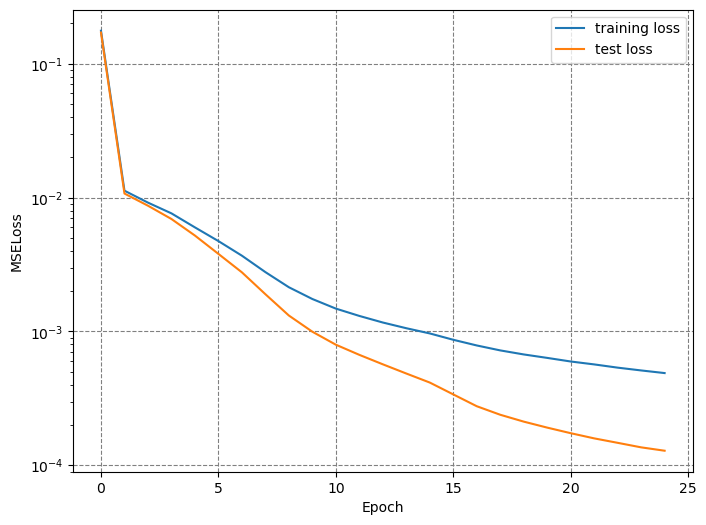

In [12]:
# plot training process
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_xlabel("Epoch")
ax.plot(train_losses, c="C0", label="training loss")
ax.plot(test_losses, c="C1", label="test loss")
ax.set_ylabel(criterion.__class__.__name__)
ax.legend(loc="upper right")
ax.set_axisbelow(True)
ax.set_yscale("log")
ax.grid(color="gray", linestyle="dashed")